1. 先撒雜訊

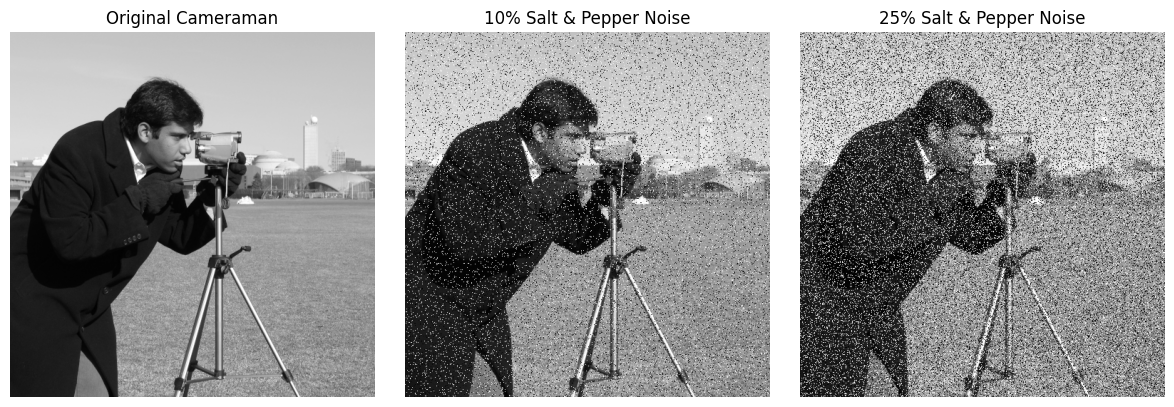

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import data

# 讀入灰階圖像
img = data.camera()  # 512x512

# 設定隨機種子
np.random.seed(42)
noise_10 = random_noise(img, mode='s&p', amount=0.10)

np.random.seed(42)  # 採用一樣的random seed
noise_25 = random_noise(img, mode='s&p', amount=0.25)

# 轉成 uint8 (方便之後cv2處理)
img_uint8 = img.astype(np.uint8)
noise_10_uint8 = (255 * noise_10).astype(np.uint8)
noise_25_uint8 = (255 * noise_25).astype(np.uint8)

# 顯示圖像
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Cameraman")
plt.imshow(img_uint8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("10% Salt & Pepper Noise")
plt.imshow(noise_10_uint8, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("25% Salt & Pepper Noise")
plt.imshow(noise_25_uint8, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


- 儲存撒完雜訊的圖像

In [2]:
# 儲存撒完雜訊的圖像
import cv2

cv2.imwrite('original.jpg', img_uint8)
cv2.imwrite('10%_noise.jpg', noise_10_uint8)
cv2.imwrite('25%_noise.jpg', noise_25_uint8)
print('Original and noise image saved.')

Original and noise image saved.


2. Normal median filter

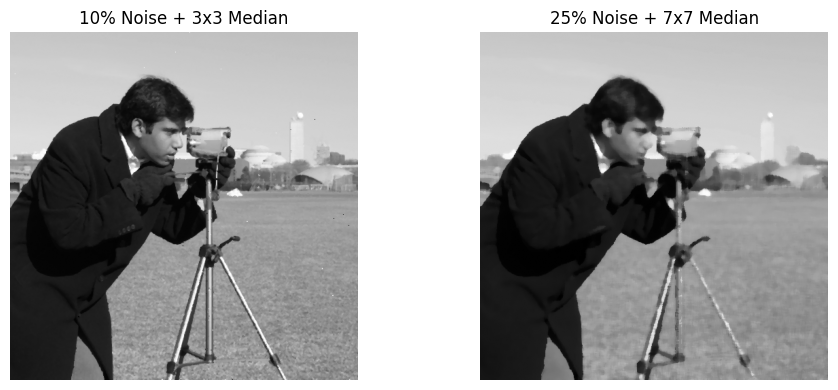

In [9]:
import numpy as np

def median_filter(img, ksize=3):
    assert ksize % 2 == 1, "Kernel size must be odd."
    
    pad_size = ksize // 2
    padded_img = np.pad(img, pad_size, mode='edge')  # 邊界延展填補
    filtered_img = np.zeros_like(img)
    
    H, W = img.shape
    
    for i in range(H):
        for j in range(W):
            # 取出鄰域區塊
            window = padded_img[i:i+ksize, j:j+ksize]
            median_val = np.median(window)
            filtered_img[i, j] = median_val
            
    return filtered_img.astype(np.uint8)


# 套用 median filter
filtered_3x3 = median_filter(noise_10_uint8, ksize=3)
filtered_7x7 = median_filter(noise_25_uint8, ksize=7)

# 顯示原始與濾波後的結果
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("10% Noise + 3x3 Median")
plt.imshow(filtered_3x3, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("25% Noise + 7x7 Median")
plt.imshow(filtered_7x7, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

- 儲存圖片

In [5]:
# 儲存median filter的圖像

cv2.imwrite('original.jpg', img_uint8)
cv2.imwrite('10%_3x3.jpg', filtered_3x3)
cv2.imwrite('25%_7x7.jpg', filtered_7x7)
print('Median filter image saved.')

Median filter image saved.


3. Adaptive median filter

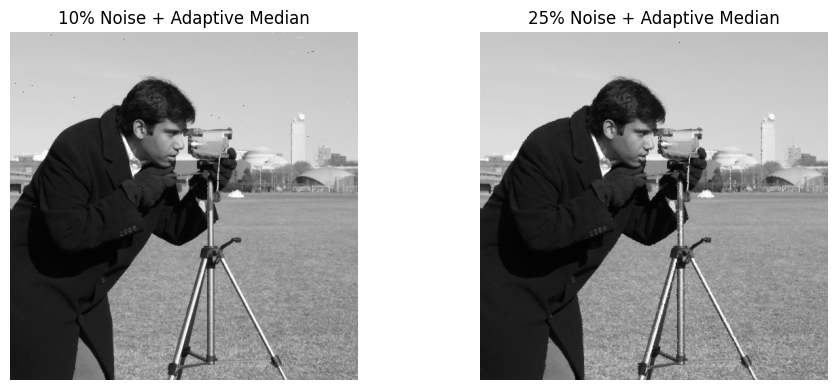

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def adaptive_median_filter(img, max_window_size=7):
    padded_img = cv2.copyMakeBorder(img, max_window_size//2, max_window_size//2, 
                                     max_window_size//2, max_window_size//2, 
                                     cv2.BORDER_REFLECT)    # 效果等同np.pad()，但速度較快
    result = img.copy()
    rows, cols = img.shape

    for i in range(rows):
        for j in range(cols):
            window_size = 3
            while window_size <= max_window_size:
                half = window_size // 2
                r_start, r_end = i, i + window_size
                c_start, c_end = j, j + window_size
                window = padded_img[r_start:r_end, c_start:c_end].flatten()
                
                Z_min = np.min(window)
                Z_max = np.max(window)
                Z_med = np.median(window)
                Z_xy = padded_img[i + half, j + half]

                A1 = Z_med - Z_min
                A2 = int(Z_med) - int(Z_max)

                if A1 > 0 and A2 < 0:
                    B1 = Z_xy - Z_min
                    B2 = int(Z_xy) - int(Z_max)
                    if B1 > 0 and B2 < 0:
                        result[i, j] = Z_xy
                    else:
                        result[i, j] = Z_med
                    break
                else:
                    window_size += 2
            else:
                result[i, j] = Z_xy

    return result.astype(np.uint8)

# 套用 Adaptive Median Filter
filtered_adapt_10 = adaptive_median_filter(noise_10_uint8, max_window_size=7)
filtered_adapt_25 = adaptive_median_filter(noise_25_uint8, max_window_size=7)

# 顯示結果
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("10% Noise + Adaptive Median")
plt.imshow(filtered_adapt_10, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("25% Noise + Adaptive Median")
plt.imshow(filtered_adapt_25, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


- 儲存圖片

In [6]:
# 儲存adaptive median filter的圖像

cv2.imwrite('original.jpg', img_uint8)
cv2.imwrite('10%_adapt.jpg', filtered_adapt_10)
cv2.imwrite('25%_adapt.jpg', filtered_adapt_25)
print('Adaptive median filter image saved.')

Adaptive median filter image saved.
